In [1]:
import numpy as np
from sentence_transformers import SentenceTransformer
from text_untils import *
import pickle
import pandas as pd
import json
import random
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [2]:
json_objects = []

with open('./data/backup/temp.json', 'r', encoding='utf-8') as file:
    for line in file:
        try:
            json_object = json.loads(line)
            json_objects.append(json_object)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")

df = pd.json_normalize(json_objects)

In [3]:
df.sample(5)

,_id,title,date_answer,field,reference,conclusion,description,quote.content,quote.name
5510,653a8b2d1e06875841d15b81,Mức phạt đối với hành vi chậm trình phê duyệt ...,2020-04-25,,None,[Căn cứ Khoản 4 Điều 31 Nghị định 36/2020/NĐ-C...,Được biết có quy định mới về xử phạt chính tro...,None,None
10558,653a92cf1e06875841d1830b,Quy định chung về an toàn đối với cơ sở kinh d...,2018-06-28,,None,[Quy định chung về an toàn đối với cơ sở kinh ...,Quy định chung về an toàn đối với cơ sở kinh d...,None,None
19206,653a9f951e06875841d1c6b5,"Căn cứ lập quy hoạch thăm dò, khai thác và sử ...",2016-10-04,Vật liệu xây dựng,None,[Theo quy định hiện hành tại Nghị định 24a/201...,"Căn cứ lập quy hoạch thăm dò, khai thác và sử ...",None,None
17957,653a9d731e06875841d1bcf3,Cung cấp không đầy đủ tài liệu liên quan đến n...,2016-11-30,,None,[Mức xử lý vi phạm hành chính trong trường hợp...,Cung cấp không đầy đủ tài liệu liên quan đến n...,None,None
3774,653a880f1e06875841d14dbf,3. Dự án có yếu tố nhạy cảm về môi trường,2022-03-16,Dự án đầu tư,Việc xác định dự án có yếu tố nhạy cảm về môi ...,[Việc xác định dự án có yếu tố nhạy cảm về môi...,None,[],None


In [4]:
# random_titles = random.sample(df['title'].tolist(), 1000)

In [5]:
# output_file_path = 'original.txt'
# with open(output_file_path, 'w', encoding='utf-8') as output_file:
#     for title in random_titles:
#         output_file.write(title + '\n')

In [6]:
model = SentenceTransformer('keepitreal/vietnamese-sbert')
embeddings_title = np.load('output/sbert/embeddings.npy')

In [7]:
with open('validate.txt', 'r', encoding='utf-8') as file:
    query_list = [line.strip() for line in file.readlines()]

In [8]:
processed_queries = []
for query in query_list:
    processed_query = normalize_text(word_segment(clean_text(query)))
    # processed_query = normalize_text(remove_stopword(word_segment(clean_text(query))))
    processed_queries.append(processed_query)

In [9]:
processed_queries = [query.replace('_', ' ') for query in processed_queries]

In [10]:
similarity_scores = cosine_similarity(model.encode(processed_queries), embeddings_title)

In [11]:
max_similarity_indices = np.argmax(similarity_scores, axis=1)

In [12]:
results_df = pd.DataFrame({'Query': query_list, 'SBERT_Score': [similarity_scores[i, idx] for i, idx in enumerate(max_similarity_indices)]})
print(results_df)

                                                 Query  SBERT_Score
0    Làm thế nào nguồn nước được sử dụng trong hoạt...     0.758552
1    Các hoạt động nào trong khu vực bảo vệ đập, hồ...     0.855126
2    Những hậu quả nào xảy ra khi không thực hiện đ...     0.684277
3    Làm thế nào để xác lập và phân cấp rừng phòng ...     0.895893
4    Có được phép chăn nuôi trong khu dân cư không ...     0.754342
..                                                 ...          ...
989  Hộ gia đình, cá nhân có được Nhà nước cho thuê...     0.885554
990  Kiểm soát chiếu xạ đối với khách đến thăm, ngư...     0.911615
991  Điều kiện về PCCC tại bảo tàng, thư viện được ...     0.911823
992  Tiêu chuẩn Viện trưởng viện điều tra Bộ nông n...     0.904308
993  Phê duyệt, kiểm tra, công khai báo cáo tài chí...     0.942630

[994 rows x 2 columns]


In [13]:
average_score = results_df['SBERT_Score'].mean()

print(f"S-BERT cosine similarity score average: {average_score}")

S-BERT cosine similarity score average: 0.8783166408538818


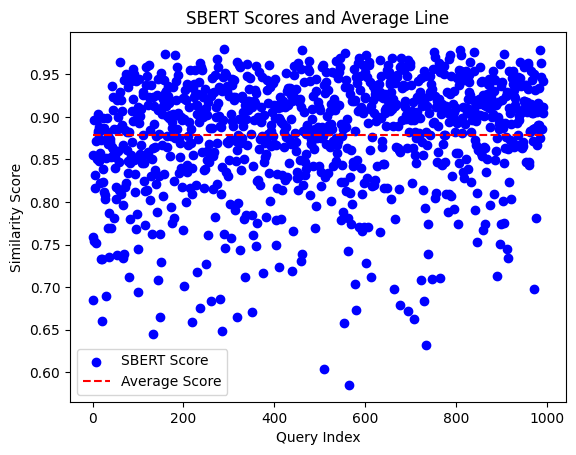

In [14]:
plt.scatter(range(len(results_df)), results_df['SBERT_Score'], label='SBERT Score', color='blue')

avg_line = np.full_like(results_df['SBERT_Score'], average_score)
plt.plot(range(len(results_df)), avg_line, label='Average Score', linestyle='--', color='red')

plt.xlabel('Query Index')
plt.ylabel('Similarity Score')
plt.title('SBERT Scores and Average Line')
plt.legend()
plt.show()

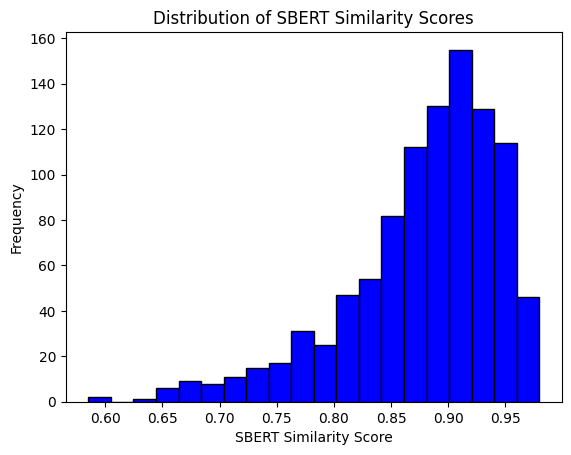

In [15]:
similarity_scores_flat = results_df['SBERT_Score'].to_numpy()

plt.hist(similarity_scores_flat, bins=20, color='blue', edgecolor='black')

plt.xlabel('SBERT Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of SBERT Similarity Scores')
plt.show()

In [16]:
processed_queries_bm25 = []
for query in query_list:
    processed_query = normalize_text(remove_stopword(word_segment(clean_text(query))))
    processed_query = processed_query.split()
    processed_queries_bm25.append(processed_query)

In [17]:
with open('output/bm25/texts.pkl', 'rb') as f:
    texts = pickle.load(f)

with open('output/bm25/bm25plus.pkl', 'rb') as f:
    bm25plus = pickle.load(f)

In [18]:
bm25plus_scores = []

for query_bm25 in processed_queries_bm25:
    top_docs = bm25plus.get_top_n(query_bm25, texts, n=1)
    scores_tmp = bm25plus.get_scores(query_bm25)
    bm25plus_scores.append(max(scores_tmp))

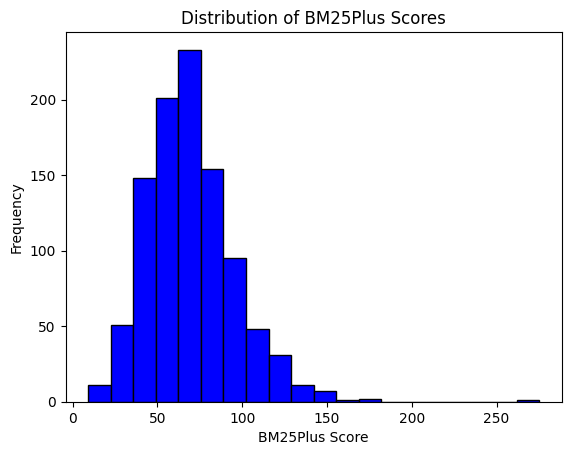

In [19]:
plt.hist(bm25plus_scores, bins=20, color='blue', edgecolor='black')

plt.xlabel('BM25Plus Score')
plt.ylabel('Frequency')
plt.title('Distribution of BM25Plus Scores')
plt.show()

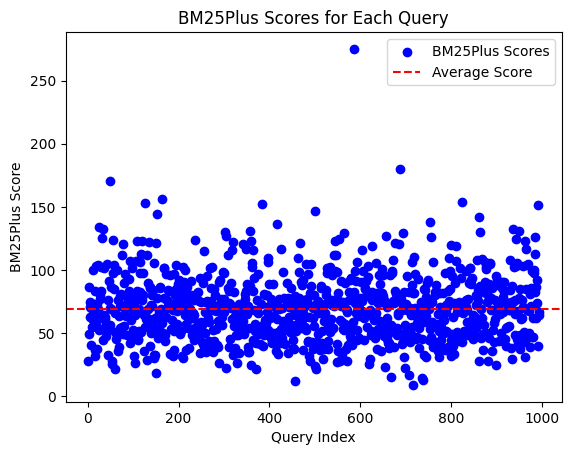

In [20]:
average_bm25plus_score = np.mean(bm25plus_scores)

plt.scatter(range(1, len(bm25plus_scores) + 1), bm25plus_scores, color='blue', marker='o', label='BM25Plus Scores')
plt.axhline(y=average_bm25plus_score, color='red', linestyle='--', label='Average Score')

plt.xlabel('Query Index')
plt.ylabel('BM25Plus Score')
plt.title('BM25Plus Scores for Each Query')
plt.legend()
plt.show()

In [21]:
print(average_bm25plus_score)

69.47368621635958
